In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats import weightstats

%matplotlib inline

### T tests

Comparing the means of two groups to each other

Assumtions: 
Both groupes are sampled from normal distributed populations
Both groups have equal variances

26.512207395272444 28.269915969020886


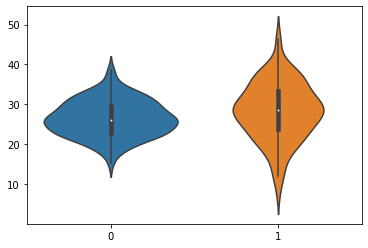

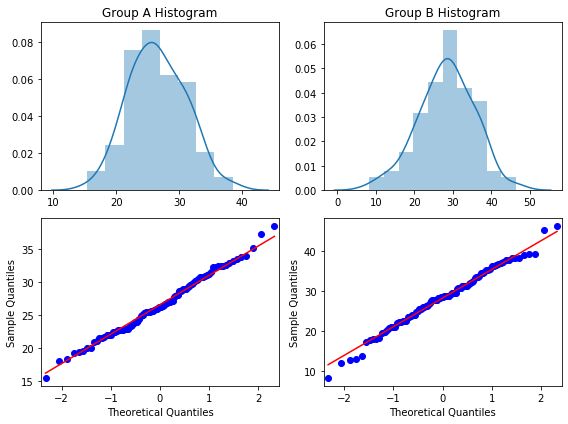

In [2]:
#Create two groups from normal distributions with mean and sd
size = 100
group_a = np.random.normal(26, scale=5, size=size)
group_b = np.random.normal(29, scale=7, size=size)

print(np.mean(group_a), np.mean(group_b))

group_data = pd.Series([group_a,group_b])
sns.violinplot(data=group_data)

#Let's pretend we don't know anythin about these two groups
#Test Normality

#Visual Checks
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
ga = sns.distplot(group_a, ax=axes[0,0])
ga.set(title='Group A Histogram')
gb = sns.distplot(group_b, ax=axes[0,1])
gb.set(title='Group B Histogram')
qa = qqplot(group_a, line='s', ax=axes[1,0])
#qa.set(title='Group A Histogram')
qb = qqplot(group_b, line='s', ax=axes[1,1])
#qb.set(title='Group B Histogram')
fig.tight_layout()

In [3]:
#Different test to check for normality include: Shapiro-Wilks, Normal (D'Agostino) and Anderson-Darling test
#From source: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

def normality_checks(group):
    #Shapiro-Wilks
    stat, p = stats.shapiro(group)
    print(f'Shapiro-Wilks: stat = {stat}, p = {p}')
    
    #Normal
    stat, p = stats.normaltest(group)
    print("\n" + f"Normal test (D'Agostino): stat = {stat}, p = {p}" + "\n")
    
    #Anderson-Darling
    print('Anderson-Darling:')
    result = stats.anderson(group)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

normality_checks(group=group_a)

Shapiro-Wilks: stat = 0.9928019046783447, p = 0.8758255839347839

Normal test (D'Agostino): stat = 0.6056254694696082, p = 0.7387374232776462

Anderson-Darling:
15.000: 0.555, data looks normal (fail to reject H0)
10.000: 0.632, data looks normal (fail to reject H0)
5.000: 0.759, data looks normal (fail to reject H0)
2.500: 0.885, data looks normal (fail to reject H0)
1.000: 1.053, data looks normal (fail to reject H0)


Test for equal variance include the Bartlett's test and the Levene's test. Bartlett's test is sensitive to departures from normality, and thus Levene's test is preferred when the population samples are generally not normally distributed.

url: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html

In [4]:
def homoscedasticity_checks(A,B):
    stat, p = stats.bartlett(A,B)
    print(f"Bartlett's test: stat = {stat}, p = {p}")
    
    stat, p = stats.levene(A,B)
    print("\n" + f"Levene's test: stat = {stat}, p = {p}")
    
homoscedasticity_checks(group_a, group_b)

Bartlett's test: stat = 21.406763861696433, p = 3.7145844796515603e-06

Levene's test: stat = 14.324086590088266, p = 0.00020387940758036303


In [5]:
#Different T tests available in scipy
#Comparing two means of indipendent samples
print(f'Mean group_a = {np.mean(group_a)}')
print(f'Mean group_b = {np.mean(group_b)}')
print(f'Difference in means = {np.mean(group_a)-np.mean(group_b)}' + "\n")
      
stat, p = stats.ttest_ind(group_a, group_b, equal_var=True)  #two-tailed!
print(f"Independent t test: stat = {stat}, p = {p}")
#stats.ttest_ind_from_stats can also be used for this purpose
#For a one sided ttest, the p value ahs to be divided by 2, look this up...

#Comparing mean of one group versus a fixed mean
stat, p = stats.ttest_1samp(group_a, 25)
print("\n" + f"One Sample t test: stat = {stat}, p = {p}")

#Comparing means of related samples using stats.ttest_ind_from_stats()
#For example: student does test, student then studies or practices, student does test again
#Did the score get impacted by the student studying or practicing?

Mean group_a = 26.512207395272444
Mean group_b = 28.269915969020886
Difference in means = -1.7577085737484417

Independent t test: stat = -2.0774324695810003, p = 0.03905172814859083

One Sample t test: stat = 3.383560707104535, p = 0.0010263438017052452


In [6]:
#Using statsmodels compare means
d1 = weightstats.DescrStatsW(group_a)
d2 = weightstats.DescrStatsW(group_b)
tstat, p, df = weightstats.CompareMeans(d1,d2).ttest_ind(alternative='two-sided',
                                                      usevar='pooled')
print(f"Independent t test: stat = {tstat}, p = {p}, df = {df}")

#statsmodels has built in function to calculate confidence interval for the t test

lower, upper = weightstats.CompareMeans(d1,d2).tconfint_diff(alpha=.05, 
                                                      alternative='two-sided',
                                                      usevar='pooled')

print(f"Lower Confidence interval: {lower}")
print(f"Upper Confidence Interval: {upper}")

#Or shorter:
weightstats.CompareMeans(d1,d2).summary()

Independent t test: stat = -2.077432469581004, p = 0.039051728148590495, df = 198.0
Lower Confidence interval: -3.42622588014711
Upper Confidence Interval: -0.08919126734978056


,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-1.7577,0.846,-2.077,0.039,-3.426,-0.089


### T test using PyMC3
Source: https://docs.pymc.io/notebooks/BEST.html

Some of the problems with traditional frequentist hypothesis testing: 


>Setting up a statistical test involves several subjective choices (e.g. statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

What the bayesian approach brings to the table:

>A more informative and effective approach for comparing groups is one based on estimation rather than testing, and is driven by Bayesian probability rather than frequentist. That is, rather than testing whether two groups are different, we instead pursue an estimate of how different they are, which is fundamentally more informative. Moreover, we include an estimate of uncertainty associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (epistemic uncertainty) and uncertainty due to the inherent stochasticity of the system (aleatory uncertainty).

>...set the hyperparameters to the pooled empirical mean of the data and twice the pooled empirical standard deviation, which applies very diffuse information to these quantities (and importantly, does not favor one or the other a priori).

In [7]:
mu_mean = np.mean(group_a+group_b)
mu_sd = np.std(group_a+group_b)*2
print(mu_mean, mu_sd)

54.78212336429335 16.497342074319434


>The group standard deviations will be given a uniform prior over a plausible range of values for the variability of the outcome variable. ... In Kruschke’s original model, he uses a very wide uniform prior for the group standard deviations, from the pooled empirical standard deviation divided by 1000 to the pooled standard deviation multiplied by 1000.

In [8]:
sd_low = np.std(group_a+group_b)/100
sd_high = np.std(group_a+group_b)*100

In [9]:
#Priors
with pm.Model() as model:
    group_a_mean = pm.Normal('group_a_mean', mu=mu_mean, sd=mu_sd)
    group_b_mean = pm.Normal('group_b_mean', mu=mu_mean, sd=mu_sd)
    
    group_a_std = pm.Uniform('group_a_std', lower=sd_low, upper=sd_high)
    group_b_std = pm.Uniform('group_b_std', lower=sd_low, upper=sd_high)
    
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

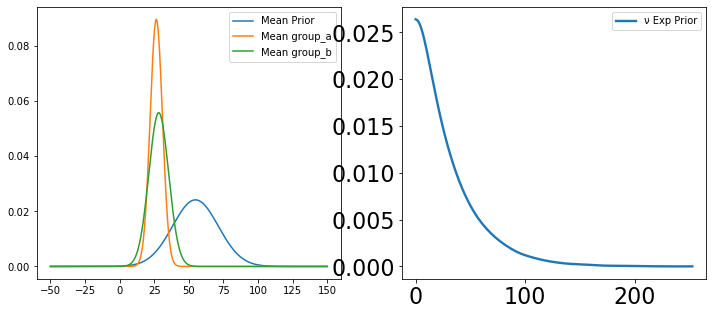

In [10]:
idx = np.arange(-50,150, 0.1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.lineplot(idx,stats.norm.pdf(idx,mu_mean,mu_sd), label='Mean Prior', ax=axes[0])
sns.lineplot(idx,stats.norm.pdf(idx,np.mean(group_a),np.std(group_a)),label='Mean group_a', ax=axes[0])
sns.lineplot(idx,stats.norm.pdf(idx,np.mean(group_b),np.std(group_b)),label='Mean group_b', ax=axes[0])
#In PyMC3 exponential has one parameter Lambda.
#In scipy stats.expon has one parameter scale which is 1 divided by lambda
pm.kdeplot(np.random.exponential(30, size=10000), label='ν Exp Prior', ax=axes[1]); #ν =/ degrees of freedom?

In [11]:
#Likelihoods
with model:
    #transform std to precision
    λ1 = group_a_std**-2
    λ2 = group_b_std**-2

    group1 = pm.StudentT('group_a', nu=ν, mu=group_a_mean, lam=λ1, observed=group_a)
    group2 = pm.StudentT('group_b', nu=ν, mu=group_b_mean, lam=λ2, observed=group_b)

In [12]:
print(np.std(group_a), np.sqrt(np.std(group_a)), np.std(group_a)**-2, 1/(np.std(group_a)**2))

4.446875616673607 2.1087616310701423 0.05056966026918366 0.05056966026918366


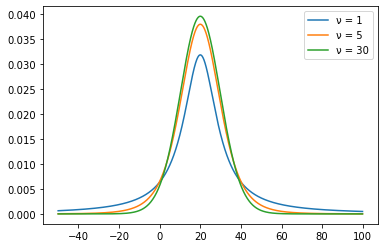

In [13]:
idx = np.arange(-50,100, 0.1)
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
nus = [1, 5, 30]
t_mean = 20
t_sd = 10
for ν in nus:
    sns.lineplot(idx,stats.t.pdf(idx,df=ν, loc=t_mean,scale=t_sd), label=f'ν = {ν}')
#sns.lineplot(idx,stats.t.pdf(idx,np.mean(group_a),np.std(group_a)),label='Mean group_a')

In [14]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group_a_mean - group_b_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group_a_std - group_b_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group_a_std**2 + group_b_std**2) / 2))

In [15]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, group_b_std, group_a_std, group_b_mean, group_a_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1420.60draws/s]


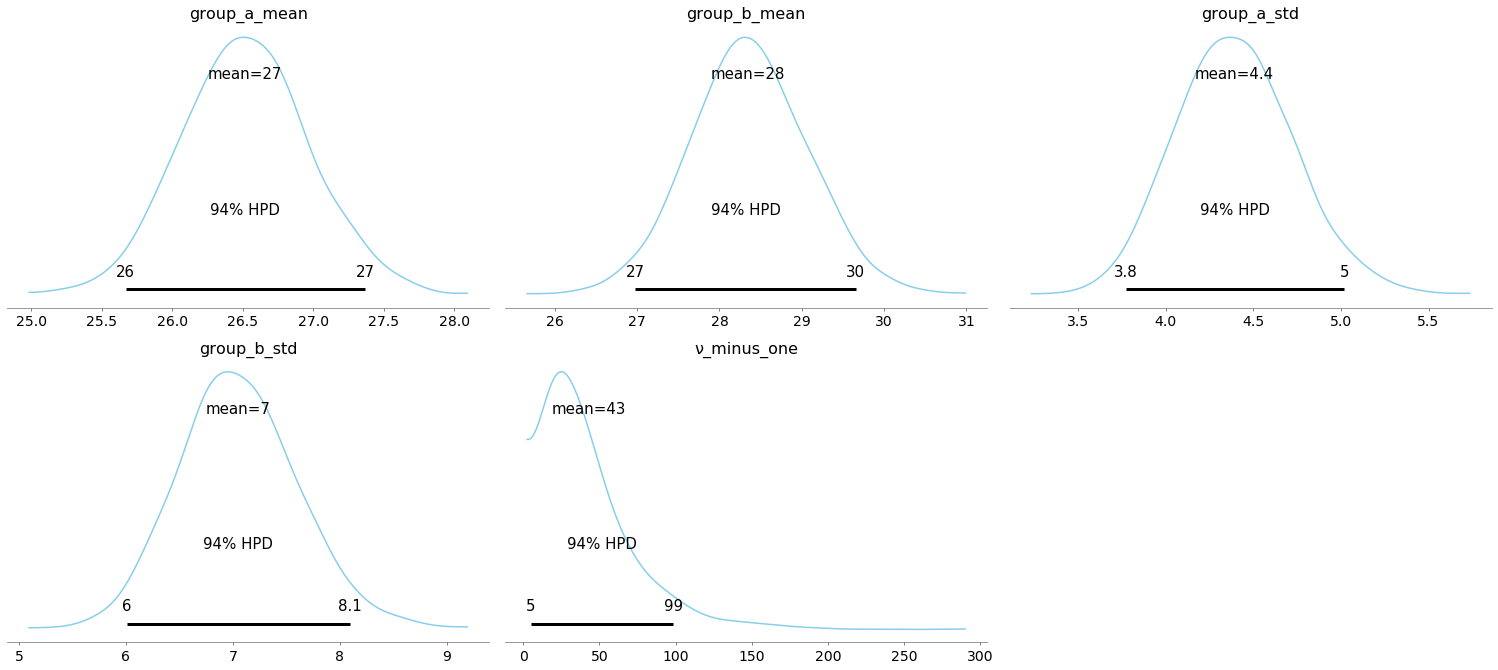

In [16]:
pm.plot_posterior(trace, var_names=['group_a_mean','group_b_mean', 'group_a_std', 'group_b_std', 'ν_minus_one'],
                  color='#87ceeb');

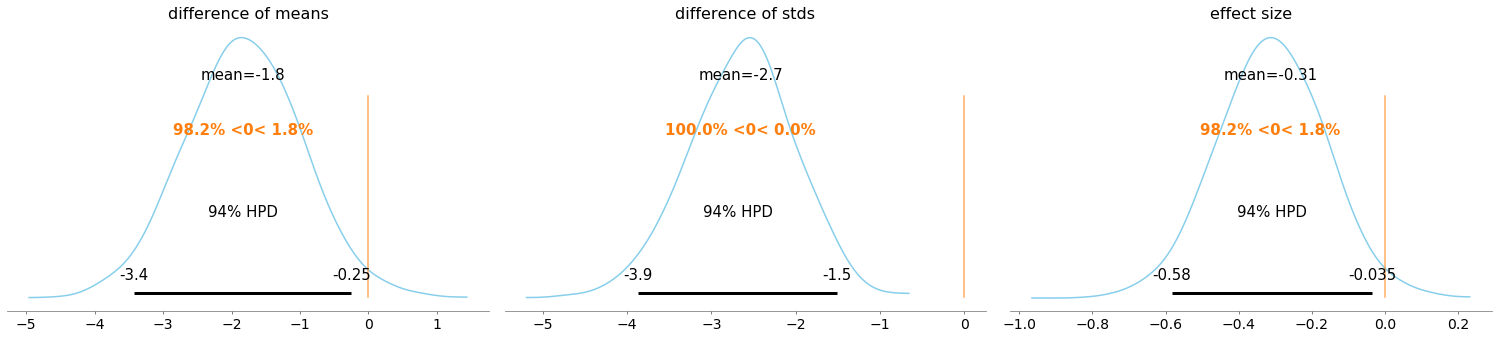

In [17]:
pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

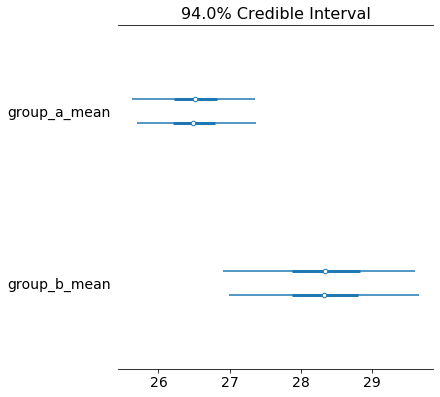

In [18]:
pm.forestplot(trace, var_names=['group_a_mean',
                                'group_b_mean']);

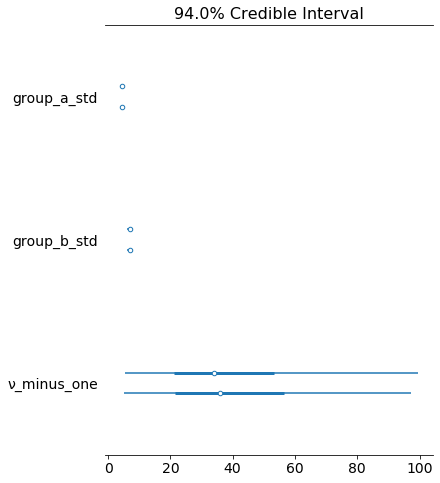

In [19]:
pm.forestplot(trace, var_names=['group_a_std',
                               'group_b_std',
                               'ν_minus_one']);

In [20]:
pm.summary(trace, varnames=['difference of means', 'difference of stds', 'effect size'])


/Users/mattijsbeirinckx/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
difference of means,-1.834,0.851,-3.430,-0.252,0.015,0.010,3444.0,3383.0,3452.0,2732.0,1.0
difference of stds,-2.654,0.635,-3.872,-1.508,0.009,0.007,4800.0,4581.0,4835.0,3456.0,1.0
effect size,-0.314,0.147,-0.583,-0.035,0.002,0.002,3468.0,3424.0,3472.0,2701.0,1.0
